#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install -q catboost

In [2]:
# Необходимые библиотеки
import time
import os
import warnings
import pathlib
from pathlib import Path
from math import sqrt

# Импорт библиотек для анализа данных
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# Модели
import lightgbm as lgb
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, FunctionTransformer

# Отключаем предупреждения
warnings.filterwarnings("ignore")

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Библиотеки импортировали - отлично!

In [4]:
#Чтение и сортировка данных
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Вывод:**     
В данных присутствует информация с 1 марта 2018 года по 31 августа 2018 года. Пропусков нет.

In [5]:
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
# Ресемплирование по 1 часу
data = data.resample('1H').sum()

<Figure size 1080x720 with 0 Axes>

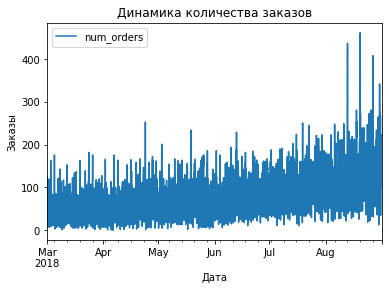

In [7]:
plt.figure(figsize=(15, 10))
data.plot()
plt.title('Динамика количества заказов')
plt.xlabel('Дата')
plt.ylabel('Заказы');

## Анализ

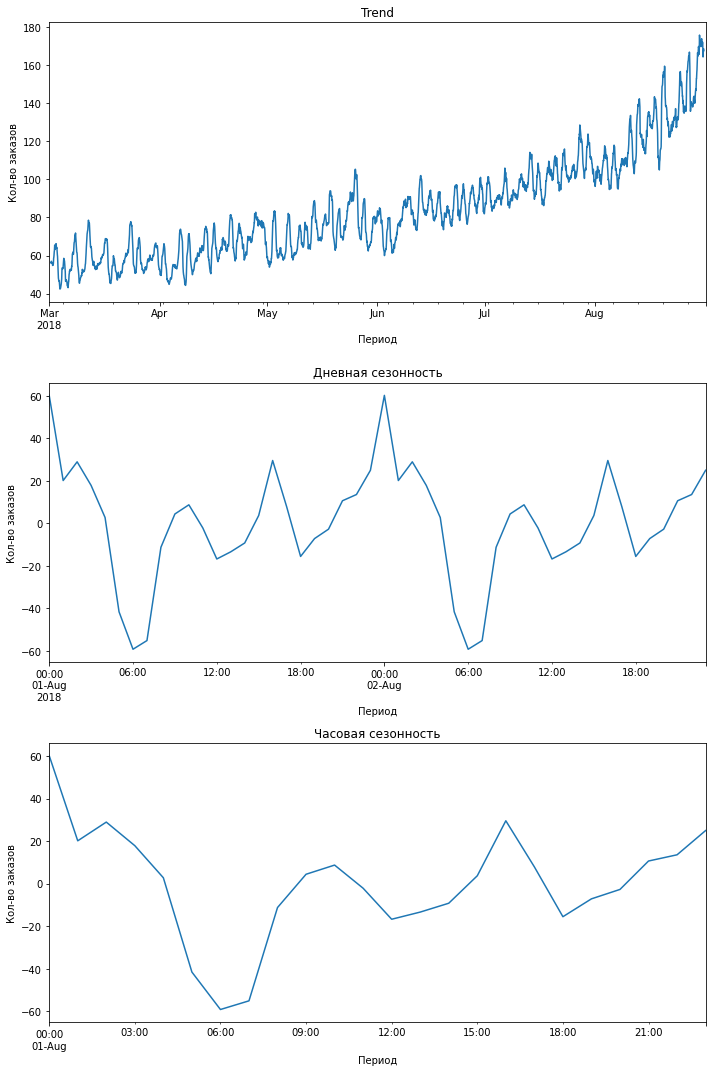

In [8]:
#Построим графики тренда за весь период и сезонности за два дня
decomposed = seasonal_decompose(data)
plt.figure(figsize=(10,15))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Дневная сезонность')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.subplot(313)
decomposed.seasonal['2018-08-01':'2018-08-01'].plot(ax=plt.gca())
plt.title('Часовая сезонность')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')

plt.tight_layout()

**Вывод:**   
- По графику `Trend` мы видим рост заказов с каждым месяцем.   
- По графику `Дневная сезонность`мы наблюдаем повышение заказов к 00:00 часам и уменьшение заказов к 06:00.   
- По графику `Часовая сезонность` наблюдается рост заказов с 6 часов.   
Благодаря графику тренда, мы видим, что в летний период число заказов значительно увеличивается, это связано в большей степени с периодом отпусков.

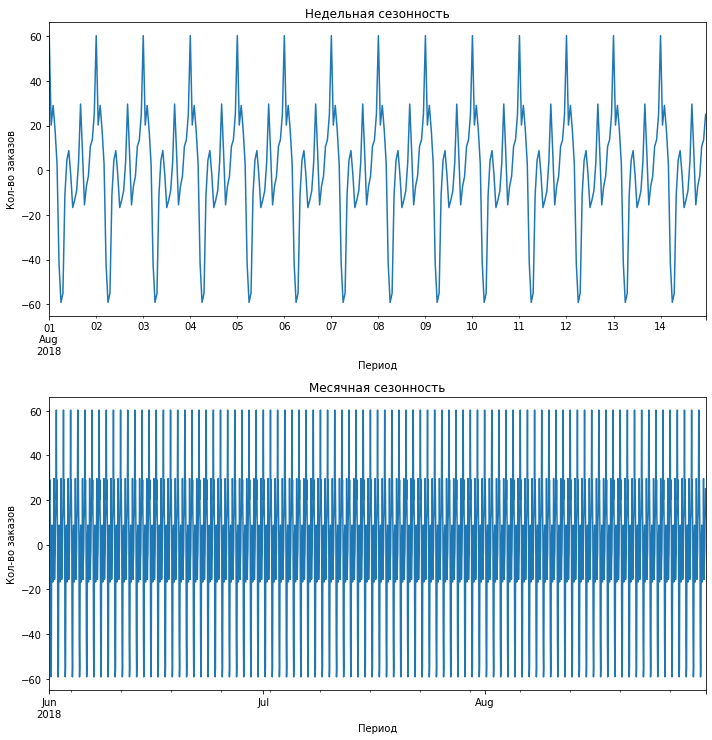

In [9]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(10,15))


plt.subplot(311)
decomposed.seasonal['2018-08-01':'2018-08-14'].plot(ax=plt.gca())
plt.title('Недельная сезонность')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')
plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Месячная сезонность')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов')

plt.tight_layout()

По графикам `Недельная сезонность` и `Месячная сезонность` сложно делать выводы, они довольно идентичны и для анализа не со всем подходят.

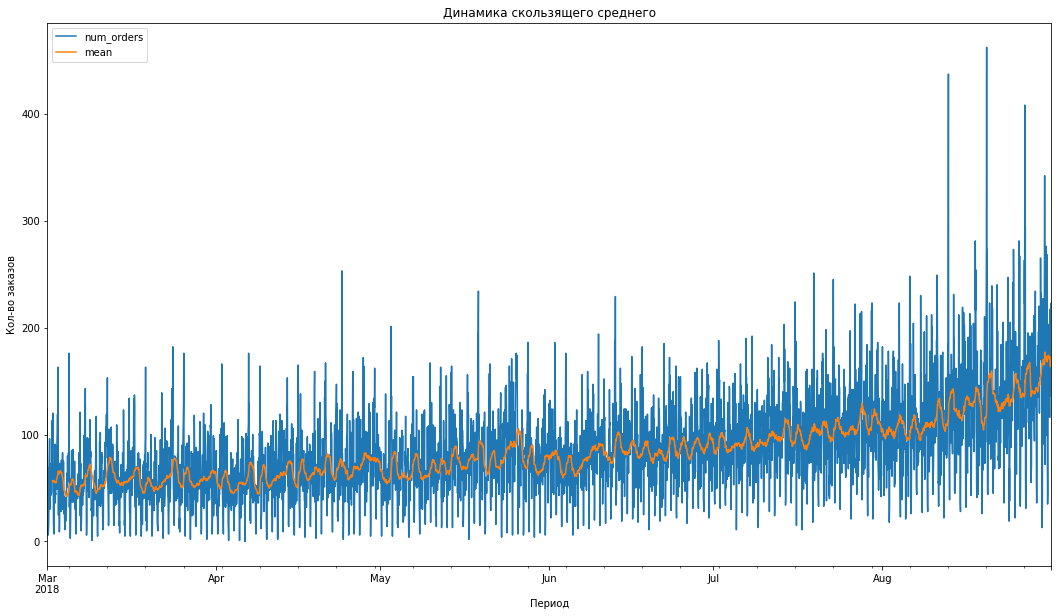

In [11]:
figsize = (18,10)
data['mean'] = data['num_orders'].rolling(24,closed='left').mean()
data.plot(figsize=figsize)
plt.title('Динамика скользящего среднего')
plt.xlabel('Период')
plt.ylabel('Кол-во заказов');

**Вывод:**   
График получился не стационнарным.

Предотвратим утечку информации, используя closed='left'

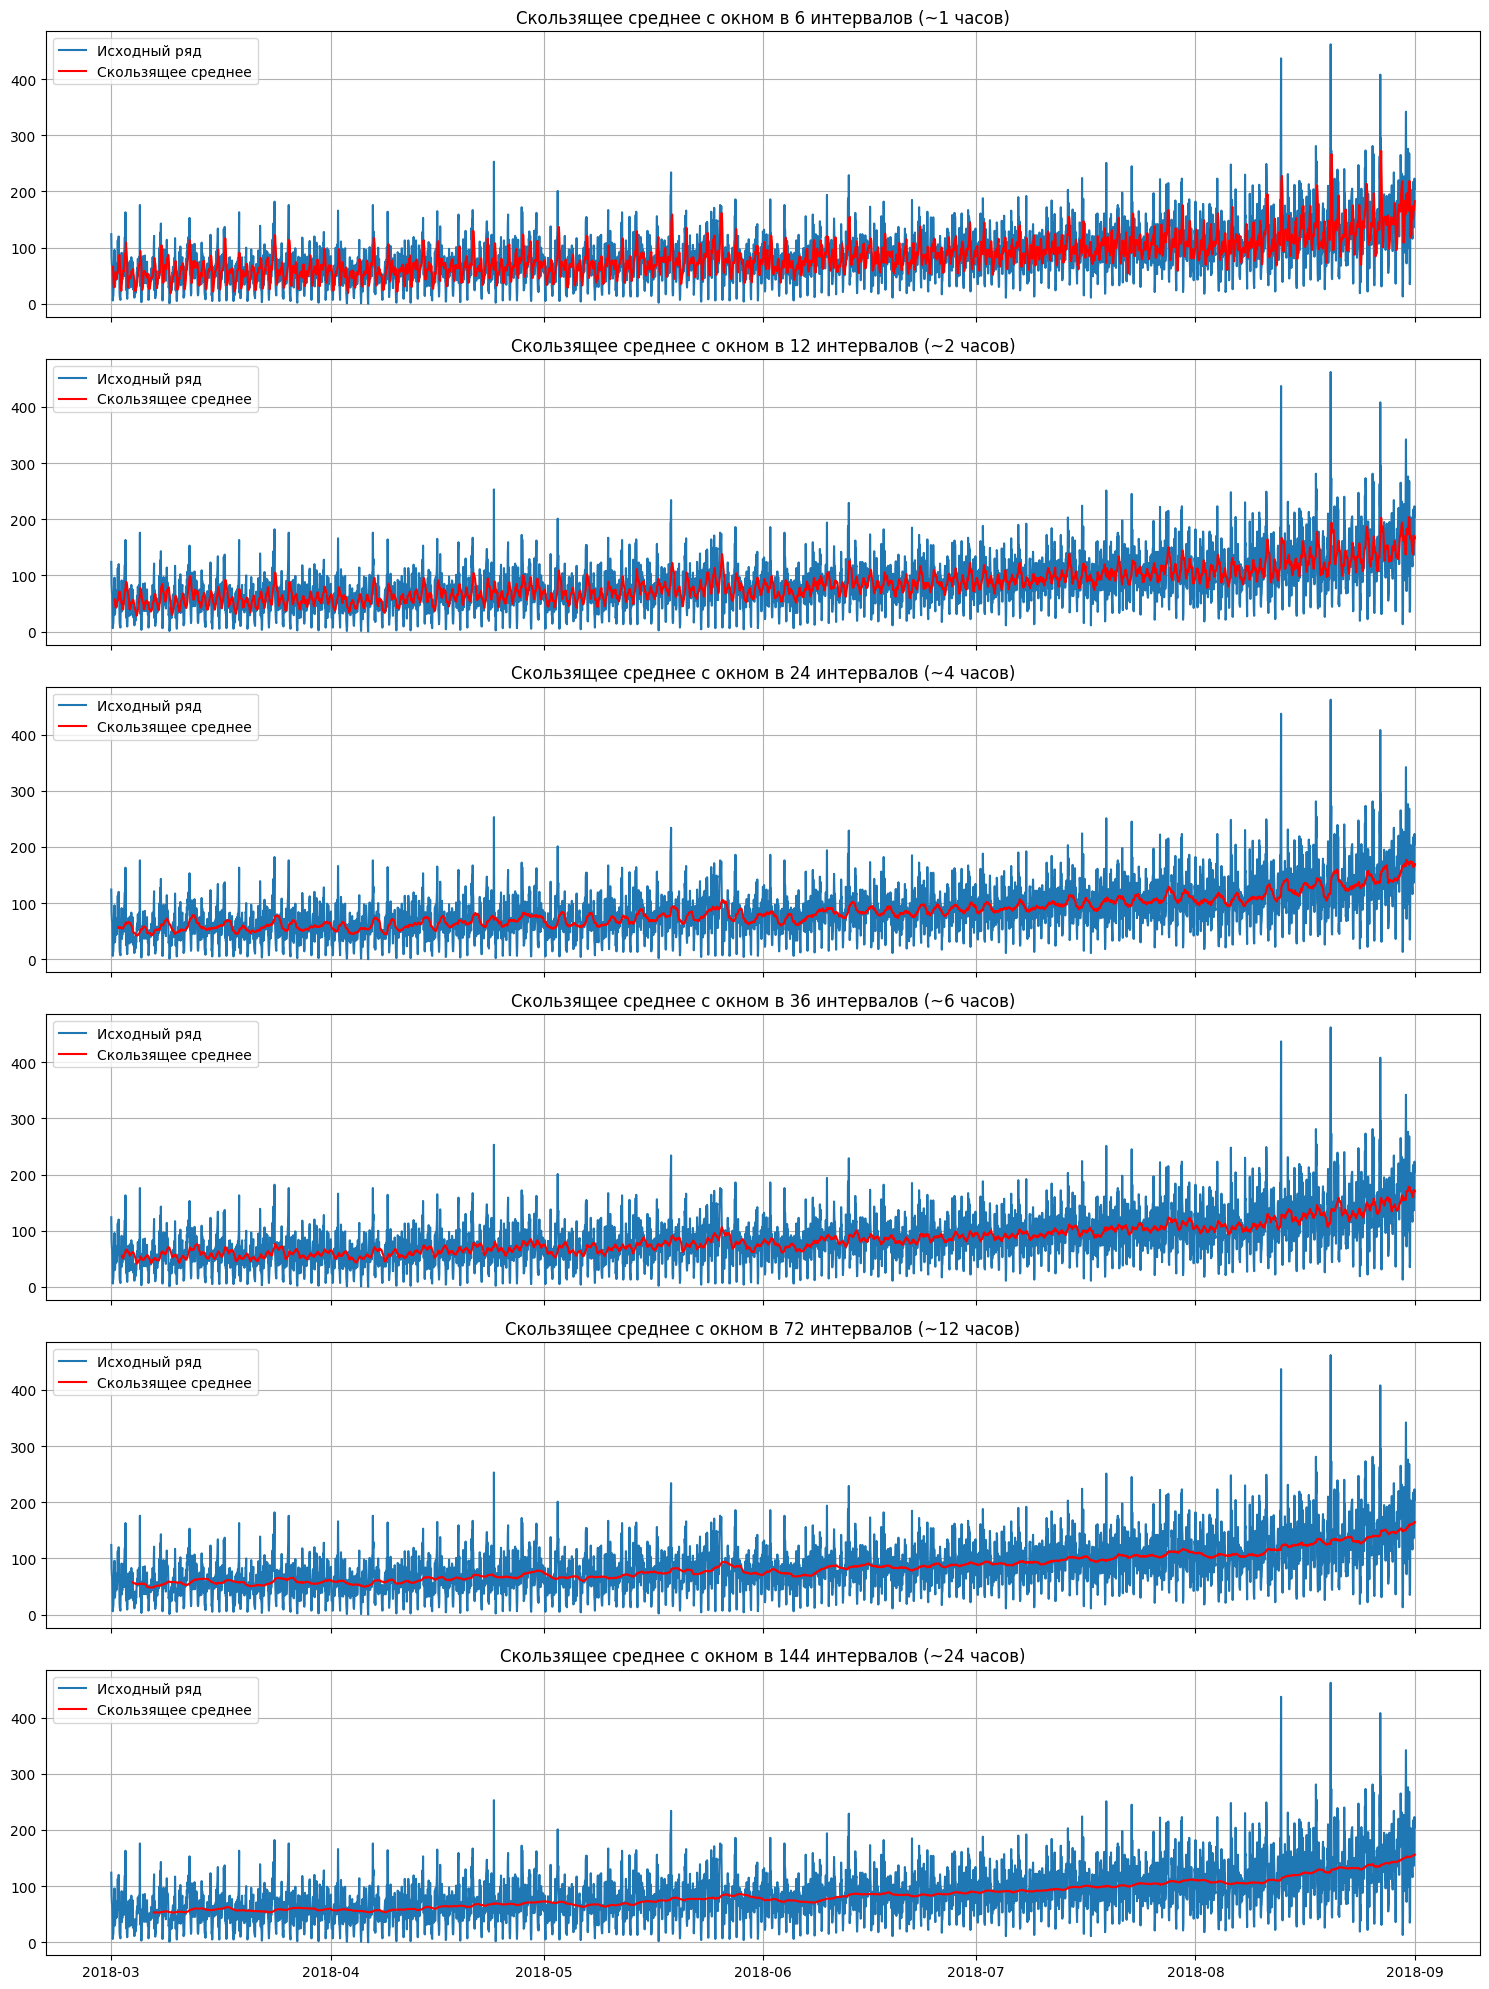

In [11]:
# Определяем размеры окон для анализа: 1, 2, 4, 6, 12, 24 часа
# Поскольку данные имеют 10-минутные интервалы, каждый час будет содержать 6 интервалов
window_sizes = [6, 12, 24, 36, 72, 144]  # Это соответствует 1, 2, 4, 6, 12, 24 часам

# Создаем фигуру и массив осей для субплотов
fig, axes = plt.subplots(len(window_sizes), 1, figsize=(15, 20), sharex=True)

# Итерируем по размерам окон и строим графики скользящего среднего
for i, window_size in enumerate(window_sizes):
    # Считаем скользящее среднее с заданным окном
    rolling_mean = data['num_orders'].rolling(window=window_size, closed='left').mean()

    # Строим график исходного ряда и скользящего среднего
    axes[i].plot(data.index, data['num_orders'], label='Исходный ряд')
    axes[i].plot(data.index, rolling_mean, label='Скользящее среднее', color='red')

    # Добавляем заголовок и легенду
    axes[i].set_title(f'Скользящее среднее с окном в {window_size} интервалов (~{window_size//6} часов)')
    axes[i].legend()
    axes[i].grid(True)

# Показываем графики
plt.tight_layout()
plt.show()

Вывод - ряд нестационарен

Здесь мы видим повышение заказов к пятнице и уменьшение количества заказов в воскресенье. Удивительно, что в понедельник количество заказов снова выходит на пик и ко вторнику падает до минимального значения.

In [12]:
data.describe()

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
max_lag = 24
rolling_mean_size = 48

In [15]:
make_features(data,max_lag,rolling_mean_size)

## Обучение

In [16]:
# Функция для вычисления RMSE
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [17]:
# Создание объекта scorer для использования в GridSearchCV
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [18]:
# Подготовка данных
train, test = train_test_split(data, shuffle=False, random_state=42, test_size=0.1)

train = train.dropna()

In [19]:
train_features = train.drop('num_orders', axis=1)
test_features = test.drop('num_orders', axis=1)

In [20]:
train_target = train['num_orders']
test_target = test['num_orders']

In [21]:
# Инициализация словаря для результатов
results = {
    "RandomForest": {},
    "CatBoost": {},
    "LightGBM": {}
}

In [22]:
splits = TimeSeriesSplit(n_splits=3)

In [23]:
# RandomForest
RF = RandomForestRegressor(random_state=42)
parametrs = {"max_depth": [1,10], "n_estimators": [100, 150, 10]}
RF_grid = GridSearchCV(RF, parametrs, cv=splits, scoring=rmse_scorer, verbose=True, n_jobs=-1)
RF_grid.fit(train_features, train_target)

In [24]:
# CatBoost
catboost = CatBoostRegressor(loss_function='RMSE',
                             early_stopping_rounds=50,
                             random_state=42, silent=True)
Cat_params = {'depth': [5, 10], 'learning_rate': [0.01, 0.01]}
catboost_grid = GridSearchCV(catboost, Cat_params, cv=splits,
                             verbose=True, n_jobs=-1)
catboost_grid.fit(train_features, train_target)

In [25]:
# LightGBM
lgbm = lgb.LGBMRegressor(random_state=42, verbose=-1)
LightGBM_params = {
    'num_leaves': [20, 38],
    'min_data_in_leaf': [20, 30],
    'max_depth': [-1, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200]
}
lgbm_grid = GridSearchCV(lgbm, LightGBM_params,
                         scoring=rmse_scorer, cv=splits, verbose=True)
lgbm_grid.fit(train_features, train_target)

## Тестирование

In [26]:
# Сохранение результатов RMSE на валидационной выборке
results['RandomForest']['RMSE Valid'] = RF_grid.best_score_
results['CatBoost']['RMSE Valid'] = catboost_grid.best_score_
results['LightGBM']['RMSE Valid'] = lgbm_grid.best_score_

In [27]:
# Выбор лучшей модели
best_model_name = min(results, key=lambda x: results[x]['RMSE Valid'])
best_model = {'RandomForest': RF_grid,
              'CatBoost': catboost_grid,
              'LightGBM': lgbm_grid}[best_model_name].best_estimator_

# Тестирование лучшей модели на тестовой выборке
test_rmse = (mean_squared_error(test_target, best_model.predict(test_features))) ** 0.5

# Вывод результатов
print(f"Лучшая модель: {best_model_name}, RMSE на тестовой выборке: {test_rmse}")

**RMSE на тестовых данных:**

Лучшая модель: RandomForest, RMSE на тестовой выборке: 44.16

RandomForest удовлетворяет критерию (RMSE < 48) на тестовых данных.